## <span style="color:blue">  Numerical exercises 8</span>
The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on <span style="color:red">two variational parameters: $\sigma$ and $\mu$</span>.

### Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
<span style="color:red">Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:</span>
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

### Commenti sull'implementazione

Il programma C++ implementa l'algoritmo di **Monte Carlo Variazionale (VMC)** per calcolare il valore di aspettazione dell'energia dello stato fondamentale, $\langle \hat{H} \rangle_T$, per una singola particella quantistica in un potenziale unidimensionale. Questo valore viene calcolato come media della cosiddetta "energia locale", $E_L(x) = \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$, campionando posizioni secondo la distribuzione di probabilità data dal modulo quadro della funzione d'onda di prova, $|\Psi_T(x)|^2$.

#### Algoritmo di Metropolis

Il cuore della simulazione è l'algoritmo di Metropolis, utilizzato per generare una sequenza di posizioni della particella $\{x_i\}$ che segue la distribuzione di probabilità $p(x) = |\Psi_T(x)|^2$.

Il processo si svolge come segue:
1.  **Inizializzazione**: La simulazione parte da una posizione iniziale $x_0$.
2.  **Equilibrazione**: Viene eseguito un numero predefinito di passi iniziali (passi di equilibrazione) che vengono scartati. Questa fase è cruciale per garantire che il sistema "dimentichi" la sua condizione iniziale e raggiunga una configurazione tipica della distribuzione di probabilità desiderata.
3.  **Campionamento**: Dopo l'equilibrazione, l'algoritmo procede generando nuove posizioni. Ad ogni passo, partendo da una posizione corrente $x_{old}$, viene proposta una nuova posizione $x_{new}$ campionandola da una distribuzione di probabilità di transizione uniforme e simmetrica, definita in un intorno di $x_{old}$.
4.  **Accettazione/Rifiuto**: La mossa proposta viene accettata con una probabilità $\alpha = \min\left(1, \frac{|\Psi_T(x_{new})|^2}{|\Psi_T(x_{old})|^2}\right)$. Se la mossa viene rifiutata, la posizione della particella per quel passo rimane $x_{old}$.

Questo procedimento genera una catena di Markov le cui configurazioni, una volta raggiunto l'equilibrio, sono distribuite secondo $|\Psi_T(x)|^2$.

#### Calcolo dell'energia

Per ogni posizione $x_i$ campionata dopo la fase di equilibrazione, il programma calcola l'**energia locale $E_L(x_i)$**. Questa quantità è la somma del potenziale $V(x_i)$ e del termine di energia cinetica, $\frac{-\frac{\hbar^2}{2m} \nabla^2 \Psi_T(x_i)}{\Psi_T(x_i)}$, che è stato calcolato analiticamente e implementato come funzione nel codice.

Il valore di aspettazione dell'energia, $\langle \hat{H} \rangle_T$, è quindi approssimato dalla media aritmetica dei valori di energia locale calcolati:
$$\langle \hat{H} \rangle_T \approx \frac{1}{N_{steps}} \sum_{i=1}^{N_{steps}} E_L(x_i)$$
Poiché i campioni generati dall'algoritmo di Metropolis sono intrinsecamente correlati, una stima diretta dell'errore statistico sulla media sarebbe inesatta. Per superare questo problema, il programma utilizza la tecnica del **data blocking**. La sequenza di energie locali viene suddivisa in blocchi. Si calcola la media per ciascun blocco e si assume che queste medie siano statisticamente indipendenti. L'errore sulla stima finale di $\langle \hat{H} \rangle_T$ viene quindi calcolato come la deviazione standard della media di questi blocchi.

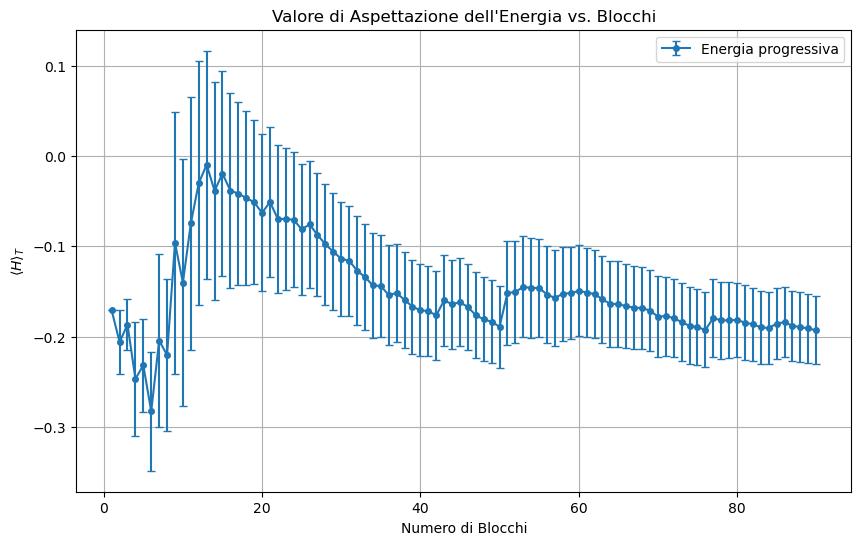

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Grafico: Energia Progressiva vs. Numero di Blocchi ---
try:
    # Carica i dati dal file: blocco, energia, errore
    block, energy, error = np.loadtxt("progressive_energy.dat", unpack=True)

    plt.figure(figsize=(10, 6))
    plt.errorbar(block, energy, yerr=error, fmt='-o', markersize=4, capsize=3, label="Energia progressiva")
    plt.xlabel("Numero di Blocchi")
    plt.ylabel(r"$\langle H \rangle_T$")
    plt.title("Valore di Aspettazione dell'Energia vs. Blocchi")
    plt.grid(True)
    plt.legend()
    plt.show()

except IOError:
    print("File 'progressive_energy.dat' non trovato.")
    print("Assicurati di aver eseguito il codice C++ modificato e che il file .dat sia nella stessa cartella del notebook.")

### Analisi dei risultati

Il grafico illustra l'andamento del valore di aspettazione dell'energia, $\langle \hat{H} \rangle_T$, in funzione del numero di blocchi utilizzati nell'analisi statistica. Ogni punto sulla curva rappresenta la media cumulativa delle energie medie di blocco, mentre le barre di errore indicano l'incertezza statistica associata a tale media.

Si osserva un comportamento tipico di una simulazione Monte Carlo analizzata con il metodo del **data blocking**:

* **Fase iniziale (pochi blocchi)**: La stima dell'energia è soggetta a grandi fluttuazioni e presenta un'incertezza statistica elevata. Questo è dovuto alla scarsità di dati su cui viene calcolata la media, rendendola molto sensibile al valore di ogni singolo blocco.

* **Fase di convergenza**: All'aumentare del numero di blocchi, la stima progressiva converge stabilizzandosi attorno a un valore specifico. Le oscillazioni si smorzano e le barre di errore si riducono progressivamente, indicando che la media sta diventando statisticamente più stabile e affidabile.

* **Fase di plateau**: La regione di plateau, raggiunta nella parte finale della simulazione (indicativamente dopo 50-60 blocchi), fornisce la migliore stima del valore di aspettazione dell'energia per i parametri variazionali ($\sigma$ e $\mu$) scelti. La dimensione decrescente delle barre d'errore, che si riduce proporzionalmente a $1/\sqrt{N_{blocchi}}$, conferma la validità del metodo nel fornire un'incertezza statistica per la misura.

In conclusione, il grafico dimostra che la simulazione ha raggiunto la convergenza, fornendo una stima affidabile per $\langle \hat{H} \rangle_T$ con un errore statistico quantificabile.

### Exercise 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a <span style="color:red">Simulated Annealing (SA) algorithm</span>.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.
- <span style="color:red">Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm</span>
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps <span style="color:red">for the set of parameters which minimize $\langle {\hat H} \rangle_T$</span>
- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

### Commenti sull'implementazione

#### Funzionamento del codice C++

Il programma C++ è diviso in due fasi principali: l'ottimizzazione dei parametri variazionali tramite **Simulated Annealing (SA)** e una successiva **simulazione di produzione** ad alta statistica con i parametri ottimizzati.

**Fase 1: Simulated Annealing (SA)**

L'obiettivo di questa fase è trovare la coppia di parametri $(\mu, \sigma)$ che minimizza il valore di aspettazione dell'energia $\langle \hat{H} \rangle_T$.

1.  **Inizializzazione**: L'algoritmo parte da una coppia iniziale di $(\mu, \sigma)$ e da una "temperatura" $T$ elevata.
2.  **Iterazione e campionamento**: Per un numero prefissato di passi, l'algoritmo:
    * Propone una nuova coppia di parametri $(\mu_{new}, \sigma_{new})$ effettuando un piccolo passo casuale a partire da quelli correnti.
    * Utilizzando i nuovi parametri, esegue una simulazione Monte Carlo completa (basata sull'algoritmo di Metropolis) per calcolare una stima dell'energia media, $\langle H \rangle_{new}$, e della sua deviazione standard.
3.  **Criterio di accettazione**: La nuova configurazione di parametri viene accettata o rifiutata secondo il criterio di Metropolis per SA:
    * Se l'energia nuova è inferiore alla migliore energia trovata finora ($\Delta E < 0$), la mossa viene sempre accettata.
    * Se l'energia è superiore, la mossa può comunque essere accettata con una probabilità $p = e^{-\Delta E / T}$. Questa probabilità è alta a temperature elevate, permettendo al sistema di "sfuggire" a minimi locali, e diminuisce con il raffreddamento.
4.  **Raffreddamento**: Dopo ogni passo, la temperatura $T$ viene ridotta di un fattore di raffreddamento (`cooling < 1`). Questo processo rende progressivamente più difficile accettare mosse che aumentano l'energia, guidando il sistema verso il minimo energetico globale.
5.  **Output SA**: Durante questo processo, il codice salva in file (`sa_energy.dat` e `sa_params.dat`) l'andamento dell'energia e la traiettoria dei parametri, che verranno poi plottati dallo script Python.

**Fase 2: Run finale**

Una volta terminato il SA, il programma utilizza la coppia di parametri $(\mu_{best}, \sigma_{best})$ che ha prodotto l'energia più bassa. Con questi valori fissi, esegue un'unica simulazione per ottenere una stima precisa dell'energia minima. I risultati di questa simulazione (energia vs blocchi, posizioni campionate e curva analitica di $|\Psi_T(x)|^2$) vengono salvati nei file `final_energy.dat`, `sampled_psi2.dat` e `analytic_psi2.dat`.

#### Funzionamento dello script Python
Oltre al semplice plotting dei risultati, lo script Python svolge due funzioni fondamentali.

#### 1. Ottenimento della Soluzione Numerica

Per validare l'accuratezza della funzione d'onda variazionale ottimizzata, lo script implementa un metodo numerico per risolvere l'equazione di Schrödinger stazionaria. Questo approccio trasforma l'equazione differenziale in un problema agli autovalori di una matrice.

1.  **Discretizzazione dello spazio**: Il dominio spaziale `x` viene discretizzato in una griglia di punti equidistanti. In questo modo, la funzione d'onda continua $\Psi(x)$ è rappresentata da un vettore contenente i suoi valori in ciascun punto della griglia.

2.  **Rappresentazione matriciale dell'Hamiltoniana**:
    * L'operatore della derivata seconda ($\frac{d^2}{dx^2}$), presente nel termine di energia cinetica, viene approssimato e trasformato in una matrice.
    * L'operatore di potenziale $V(x)$ diventa una matrice diagonale, i cui elementi sono i valori del potenziale in ogni punto della griglia.
    * Sommando queste due matrici (con le opportune costanti fisiche), si costruisce la matrice Hamiltoniana $\mathbf{H}$ del sistema.

3.  **Diagonalizzazione**: L'equazione di Schrödinger $\hat{H}\Psi = E\Psi$ si traduce quindi nel problema algebrico $\mathbf{H}\vec{\psi} = E\vec{\psi}$. Lo script utilizza la funzione `numpy.linalg.eigh` per diagonalizzare la matrice $\mathbf{H}$, ottenendo così i suoi autovalori (le energie permesse $E_n$) e i corrispondenti autovettori (le funzioni d'onda discrete $\vec{\psi}_n$).

Lo stato fondamentale corrisponde all'autovalore più basso ($E_0$), e il suo autovettore associato, una volta normalizzato, fornisce la densità di probabilità numerica di riferimento, $|\Psi_0(x)|^2$.

#### 2. Normalizzazione della funzione analitica

Un punto cruciale per il confronto grafico è la **normalizzazione**. Una densità di probabilità, per definizione, deve avere un integrale su tutto lo spazio pari a 1, rappresentando il fatto che la probabilità di trovare la particella da qualche parte è certa.

* L'istogramma delle posizioni campionate viene automaticamente normalizzato da `matplotlib` (usando l'opzione `density=True`) in modo che la sua area totale sia 1.
* La soluzione numerica, ottenuta tramite diagonalizzazione, è anch'essa già normalizzata.
* Tuttavia, la funzione analitica $f(x) = |\Psi_T(x)|^2$ calcolata dal C++ non è, in generale, normalizzata. Il suo integrale $\int f(x)dx$ dipende dai parametri $\mu$ e $\sigma$ e non è necessariamente uguale a 1.

Per effettuare un confronto corretto, lo script Python normalizza la curva analitica tramite i seguenti passaggi:

1.  **`norm_constant = np.trapz(psi2_analytic, x_analytic)`**: Utilizzando la regola del trapezio, lo script calcola l'integrale numerico della curva analitica non normalizzata. Questo valore, `norm_constant`, rappresenta l'area totale sotto la curva.
2.  **`psi2_analytic_normalized = psi2_analytic / norm_constant`**: Successivamente, ogni valore $y$ della curva analitica viene diviso per questa costante di normalizzazione. Questa operazione riscala la curva in modo che la sua nuova area sia esattamente 1, trasformandola in una densità di probabilità.

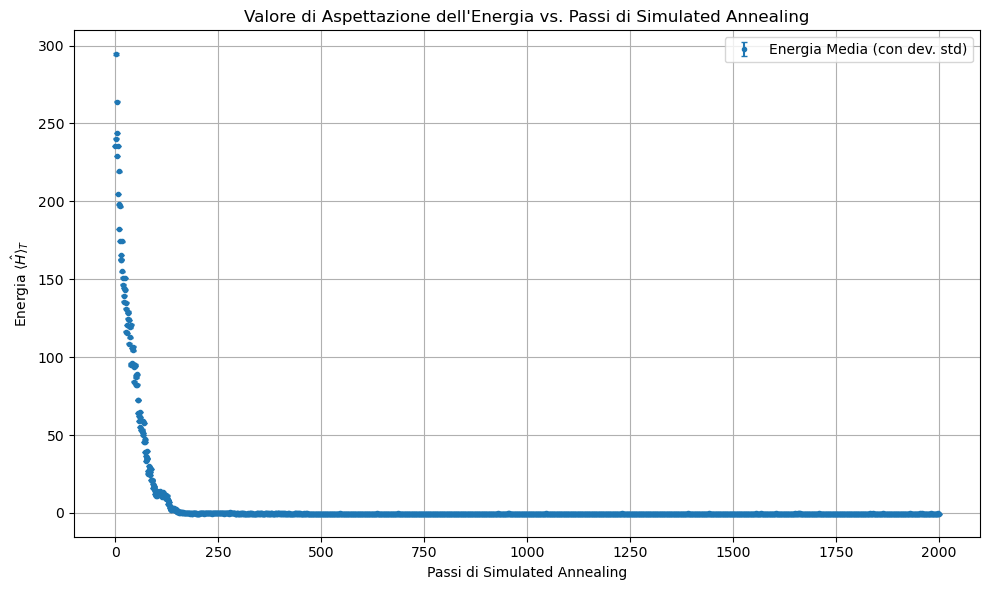

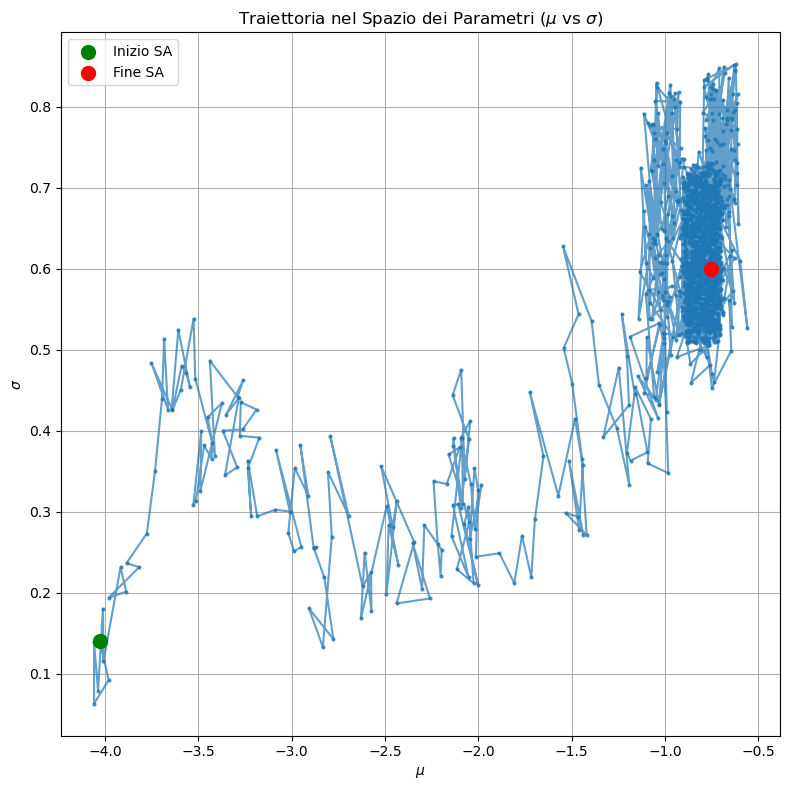

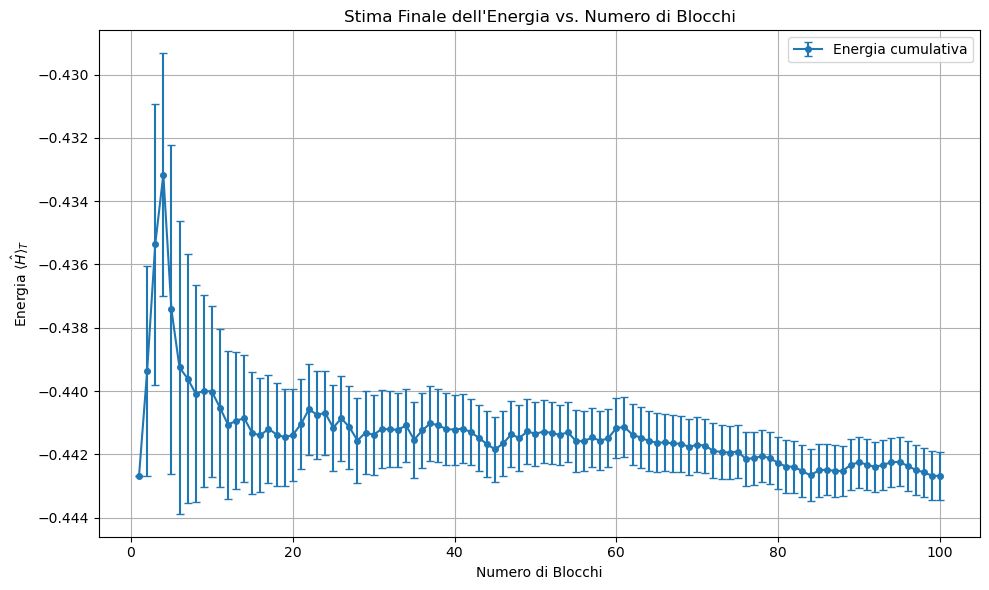


Energia dello stato fondamentale (numerica): -0.46046172


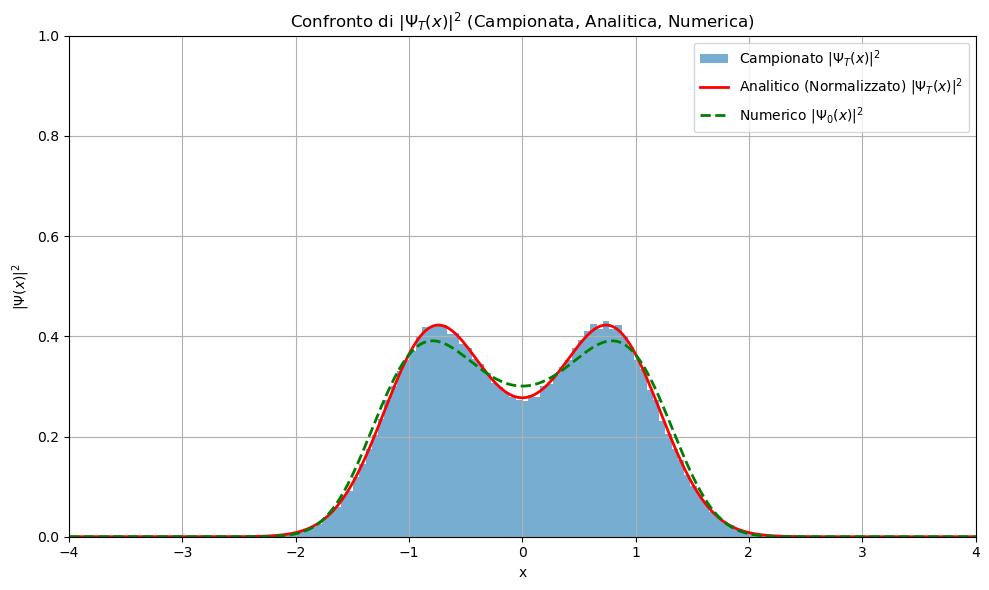

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Funzione per la soluzione numerica dell'equazione di Schrödinger ---
def solve_schrodinger_numerically(x_min=-3.0, x_max=3.0, n_points=1000):
    """
    Risolve numericamente l'equazione di Schrödinger 1D per il potenziale
    V(x) = x^4 - 2.5*x^2 utilizzando la diagonalizzazione di una matrice.
    """
    hbar = 1.0  # Costante di Planck ridotta
    m = 1.0     # Massa della particella

    x = np.linspace(x_min, x_max, n_points, endpoint=True)
    dx = x[1] - x[0]
    V = x**4 - 2.5*x**2

    # Costruzione dell'operatore della derivata seconda (matrice)
    # k>0 for diagonals above the main diagonal,
    # and k<0 for diagonals below the main diagonal
    CDiff = np.diag(np.ones(n_points-1),-1) - 2*np.diag(np.ones(n_points),0) + np.diag(np.ones(n_points-1),1)

    # Costruzione della matrice Hamiltoniana
    H = (-(hbar**2)/(2*m*dx**2)) * CDiff + np.diag(V)

    # Calcolo degli autovalori e autovettori
    E, psi_numerical = np.linalg.eigh(H)

    # Trasposizione e normalizzazione degli autovettori
    psi_numerical = np.transpose(psi_numerical)
    psi_numerical = psi_numerical / np.sqrt(dx)

    print(f"\nEnergia dello stato fondamentale (numerica): {E[0]:.8f}")
    # print(f"Energia del 1° stato eccitato (numerica): {E[1]:.8f}")
    # print(f"Energia del 2° stato eccitato (numerica): {E[2]:.8f}")

    # Restituisce le energie e le funzioni d'onda al quadrato per i primi stati
    return x, E[0], (psi_numerical[0])**2, (psi_numerical[1])**2, (psi_numerical[2])**2

# --- 2. Caricamento e analisi dei dati C++ ---

# Carica i dati di Simulated Annealing per l'energia
try:
    sa_energy_data = np.loadtxt("sa_energy.dat")
    sa_steps = sa_energy_data[:, 0]
    sa_mean_energy = sa_energy_data[:, 1]
    sa_energy_stddev = sa_energy_data[:, 2]
except IOError:
    print("Errore: file 'sa_energy.dat' non trovato. Assicurati di aver eseguito il codice C++.")
    sa_energy_data = None

# Carica i dati di Simulated Annealing per i parametri
try:
    sa_params_data = np.loadtxt("sa_params.dat")
    sa_mu_values = sa_params_data[:, 1]
    sa_sigma_values = sa_params_data[:, 2]
except IOError:
    print("Errore: file 'sa_params.dat' non trovato. Assicurati di aver eseguito il codice C++.")
    sa_params_data = None

# Carica i dati della simulazione finale (data blocking)
try:
    final_energy_data = np.loadtxt("final_energy.dat")
    block_numbers = final_energy_data[:, 0]
    final_energy_prog = final_energy_data[:, 1]
    final_energy_err_prog = final_energy_data[:, 2]
except IOError:
    print("Errore: file 'final_energy.dat' non trovato. Assicurati di aver eseguito il codice C++.")
    final_energy_data = None

# Carica i dati campionati di Psi^2
try:
    sampled_psi2_data = np.loadtxt("sampled_psi2.dat")
except IOError:
    print("Errore: file 'sampled_psi2.dat' non trovato. Assicurati di aver eseguito il codice C++.")
    sampled_psi2_data = None

# Carica i dati analitici di Psi^2
try:
    analytic_psi2_data = np.loadtxt("analytic_psi2.dat")
    x_analytic = analytic_psi2_data[:, 0]
    psi2_analytic = analytic_psi2_data[:, 1]
except IOError:
    print("Errore: file 'analytic_psi2.dat' non trovato. Assicurati di aver eseguito il codice C++.")
    analytic_psi2_data = None


# --- 3. Generazione dei Grafici ---

# Grafico 1: Energia <H>_T vs. Passi SA
if sa_energy_data is not None:
    plt.figure(figsize=(10, 6))
    plt.errorbar(sa_steps, sa_mean_energy, yerr=sa_energy_stddev, fmt='o', markersize=3, capsize=2, label='Energia Media (con dev. std)')
    plt.title('Valore di Aspettazione dell\'Energia vs. Passi di Simulated Annealing')
    plt.xlabel('Passi di Simulated Annealing')
    plt.ylabel(r'Energia $\langle \hat{H} \rangle_T$')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Grafico 2: Traiettoria nello Spazio dei Parametri (mu vs sigma)
if sa_params_data is not None:
    plt.figure(figsize=(8, 8))
    plt.plot(sa_mu_values, sa_sigma_values, marker='o', linestyle='-', markersize=2, alpha=0.7)
    plt.scatter(sa_mu_values[0], sa_sigma_values[0], color='green', s=100, label='Inizio SA', zorder=5)
    plt.scatter(sa_mu_values[-1], sa_sigma_values[-1], color='red', s=100, label='Fine SA', zorder=5)
    plt.title(r'Traiettoria nel Spazio dei Parametri ($\mu$ vs $\sigma$)')
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\sigma$')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Grafico 3: Stima Finale dell'Energia <H>_T vs. Numero di Blocchi
if final_energy_data is not None:
    plt.figure(figsize=(10, 6))
    plt.errorbar(block_numbers, final_energy_prog, yerr=final_energy_err_prog, fmt='-o', markersize=4, capsize=3, label='Energia cumulativa')
    plt.title('Stima Finale dell\'Energia vs. Numero di Blocchi')
    plt.xlabel('Numero di Blocchi')
    plt.ylabel(r'Energia $\langle \hat{H} \rangle_T$')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Grafico 4: Confronto di |Psi_T(x)|^2 (Campionata, Analitica, Numerica)
if sampled_psi2_data is not None and analytic_psi2_data is not None:
    plt.figure(figsize=(10, 6))

    # Istogramma delle posizioni campionate (rappresenta |Psi_T(x)|^2)
    plt.hist(sampled_psi2_data, bins=100, density=True, alpha=0.6, label=r'Campionato $|\Psi_T(x)|^2$')

    # Fix per normalizzazione
    # Calcola la costante di normalizzazione integrando numericamente la curva analitica
    # np.trapz è un modo semplice per calcolare l'integrale (l'area sotto la curva)
    norm_constant = np.trapz(psi2_analytic, x_analytic)
    
    # Normalizza la curva analitica
    psi2_analytic_normalized = psi2_analytic / norm_constant
    
    # Plotta la curva analitica NORMALIZZATA
    plt.plot(x_analytic, psi2_analytic_normalized, color='red', linewidth=2, label=r'Analitico (Normalizzato) $|\Psi_T(x)|^2$')

    # Soluzione numerica dell'equazione di Schrödinger
    x_numerical, E_gs_numerical, psi2_gs_numerical, _, _ = solve_schrodinger_numerically(x_min=-4.0, x_max=4.0, n_points=1000)
    plt.plot(x_numerical, psi2_gs_numerical, color='green', linestyle='--', linewidth=2, label=r'Numerico $|\Psi_0(x)|^2$')

    plt.title(r'Confronto di $|\Psi_T(x)|^2$ (Campionata, Analitica, Numerica)')
    plt.xlabel('x')
    plt.ylabel(r'$|\Psi(x)|^2$')
    plt.grid(True)
    plt.legend()
    plt.xlim([-4, 4]) # Limita l'asse x per una migliore visualizzazione
    plt.ylim([0, 1]) # Limita l'asse y per una migliore visualizzazione
    plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, "psi2_comparison.png")) # Rimosso/Commentato
    plt.show()

### Analisi dei risultati

I grafici mostrano i risultati completi del processo di ottimizzazione variazionale e della successiva analisi statistica per lo stato fondamentale del sistema quantistico in esame.

#### Andamento dell'energia durante il simulated annealing

Il primo grafico visualizza il processo di minimizzazione dell'energia $\langle \hat{H} \rangle_T$ durante l'esecuzione dell'algoritmo di **Simulated Annealing (SA)**. Si osserva che l'algoritmo parte da configurazioni con energia molto alta (corrispondenti a una "temperatura" elevata) e converge rapidamente verso una regione a bassa energia.

#### Esplorazione dello spazio dei parametri

Il secondo grafico mostra la **traiettoria** che i parametri variazionali $(\mu, \sigma)$ hanno seguito durante l'ottimizzazione SA.
* **Asse X**: Valore del parametro $\mu$.
* **Asse Y**: Valore del parametro $\sigma$.

Il percorso inizia dal punto verde e termina in quello rosso. La natura erratica della traiettoria, specialmente nelle fasi iniziali, è tipica del SA, che permette al sistema di esplorare ampiamente lo spazio dei parametri. Con il procedere dell'algoritmo, la traiettoria si concentra in una regione più ristretta, convergendo infine verso i valori ottimali di $\mu$ e $\sigma$ che minimizzano l'energia.

#### Convergenza della stima finale dell'energia

Il terzo grafico mostra il risultato della simulazione di produzione finale, eseguita con i **parametri ottimali** trovati dal SA. Come atteso, la stima dell'energia converge rapidamente a un valore di plateau stabile, che in questo caso si assesta intorno a **-0.44**. Le barre d'errore si riducono all'aumentare dei blocchi, confermando la precisione e l'affidabilità statistica del risultato finale ottenuto.

#### Confronto della densità di probabilità $|\Psi(x)|^2$

L'ultimo grafico è la validazione finale del metodo e mostra una **ottima concordanza** tra i risultati ottenuti con tre approcci diversi.
* **Istogramma (blu)**: Rappresenta la distribuzione delle posizioni campionate tramite il VMC. La sua forma corrisponde alla densità di probabilità $|\Psi_T(x)|^2$ ottenuta sperimentalmente.
* **Curva Analitica (rossa)**: È il grafico della funzione d'onda di prova $|\Psi_T(x)|^2$ (correttamente normalizzata) calcolata con i parametri ottimali.
* **Curva Numerica (verde)**: È la soluzione "esatta" della densità di probabilità dello stato fondamentale, ottenuta risolvendo numericamente l'equazione di Schrödinger.

La sovrapposizione tra le tre curve dimostra che:
1.  L'algoritmo di Metropolis ha **campionato correttamente** la distribuzione di probabilità desiderata.
2.  La forma funzionale della funzione d'onda di prova, con i parametri trovati dal SA, è un'**ottima approssimazione** del vero stato fondamentale del sistema.

### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.
(Usiamo il montecarlo sopra e non usiamo il metodo deterministico sotto perchè quello deterministico funziona per una particella, ma per 100 o 1000 particelle non va per niente. Quello montecarlo, come al solito, permette di fare i conti senza problemi.)

Ground state energy:  -0.4604658796927152
1st excited state energy:  0.0974247133176099
2nd excited state energy:  1.9717331343930193


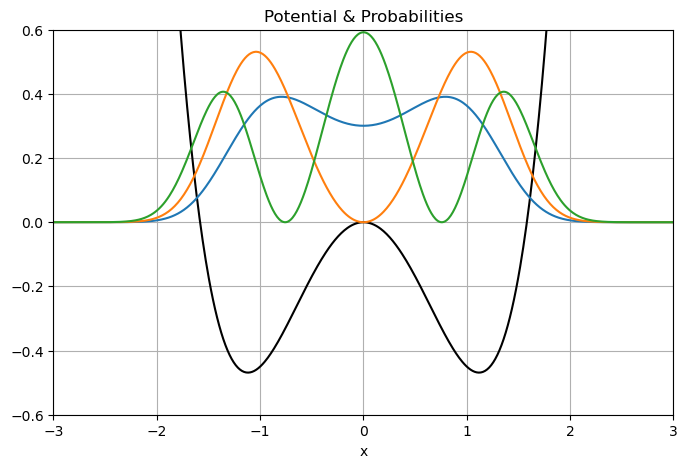

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
plt.plot(x,(psi[1])**2)
plt.plot(x,(psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()